In [14]:
import NN_Module as nnm
import torch
import numpy as np
import numpy.ma as ma
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import math
import time
import pandas as pd
from pandas import read_csv
import argparse
from matplotlib.backends.backend_pdf import PdfPages

In [15]:
out_file = '3169_0'

In [16]:
names = {}
names['cQei'] = 0
names['cQl3i'] = 1
names['cQlMi'] = 2
names['cbW'] = 3
names['cpQ3'] = 4
names['cpQM'] = 5
names['cpt'] = 6
names['cptb'] = 7
names['ctG'] = 8
names['ctW'] = 9
names['ctZ'] = 10
names['ctei'] = 11
names['ctlSi'] = 12
names['ctlTi'] = 13
names['ctli'] = 14
names['ctp'] = 15

In [17]:
save_dict = torch.load(f'./{out_file}_model+.pt')
best_model_state = save_dict['model']
parameters_save = save_dict['parameters']
input_stats = save_dict['input_stats']
output_stats = save_dict['output_stats']

In [18]:
input_stats[0].device

device(type='cuda', index=0)

In [19]:
parameters_save

{'N': 152,
 'train_size': 6619234,
 'test_size': 66860,
 'hidden_nodes': 700,
 'hidden_layers': 2,
 'batch_size': 512,
 'n_epochs': 195,
 'learning_rate': 0.0001,
 'lr_red_factor': 0.2,
 'lr_red_patience': 20.0,
 'lr_red_threshold': 1e-06,
 'weight_decay': 0.0,
 'accu_out_resolution': 100,
 'out_residual_resolution': 100}

In [20]:
model = nnm.create_model(152, 1, parameters_save)
model.load_state_dict(best_model_state)
model.eval()

Sequential(
  (0): Linear(in_features=152, out_features=700, bias=True)
  (1): ReLU()
  (2): Linear(in_features=700, out_features=700, bias=True)
  (3): ReLU()
  (4): Linear(in_features=700, out_features=700, bias=True)
  (5): ReLU()
  (6): Linear(in_features=700, out_features=1, bias=True)
)

In [21]:
actual_graph_data = {}
for key in names.keys():
    loaded = np.load(f'likelihood_{key}.npz')
    actual_graph_data[key] = {key: loaded[key], 'deltaNLL': loaded['deltaNLL']}
    actual_graph_data[key]['deltaNLL'] -= actual_graph_data[key]['deltaNLL'].min()
    actual_graph_data[key]['deltaNLL'] *= 2

In [22]:
model_graph_data = {}
for key in names.keys():
    max_inputs = actual_graph_data[key][key].max()
    min_inputs = actual_graph_data[key][key].min()
    num_inputs = 1000
    inputs = np.linspace(min_inputs, max_inputs, num_inputs)
    inputs_all = np.zeros((num_inputs, 152))
    inputs_all[:,names[key]] = inputs
    inputs_all[:,16:32] = inputs_all[:,0:16]**2
    idx = 32
    for i in range(16):
        for j in range(i):
            inputs_all[:,idx] = inputs_all[:,i] * inputs_all[:,j]
            idx += 1
    std_inputs = nnm.affine_transform(torch.from_numpy(inputs_all).float().cuda(), input_stats)
    std_outputs = model(std_inputs)
    outputs = nnm.affine_untransform(std_outputs, output_stats).cpu().detach().numpy().flatten()
    outputs -= outputs.min()
    outputs *= 2
    model_graph_data[key] = {key: inputs, 'deltaNLL': outputs}

In [23]:
diff_graph_data = {}
for key in names.keys():
    inputs = actual_graph_data[key][key]
    num_inputs = inputs.shape[0]
    inputs_all = np.zeros((num_inputs, 152))
    inputs_all[:,names[key]] = inputs
    inputs_all[:,16:32] = inputs_all[:,0:16]**2
    idx = 32
    for i in range(16):
        for j in range(i):
            inputs_all[:,idx] = inputs_all[:,i] * inputs_all[:,j]
            idx += 1
    std_inputs = nnm.affine_transform(torch.from_numpy(inputs_all).float().cuda(), input_stats)
    std_outputs = model(std_inputs)
    outputs = nnm.affine_untransform(std_outputs, output_stats).cpu().detach().numpy().flatten()
    outputs -= outputs.min()
    outputs *= 2
    diff_graph_data[key] = {key: inputs, 'deltaNLL': actual_graph_data[key]['deltaNLL'] - outputs}

/srv/ipykernel_22/1315083676.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  diff_graphs[key] = plt.subplots()


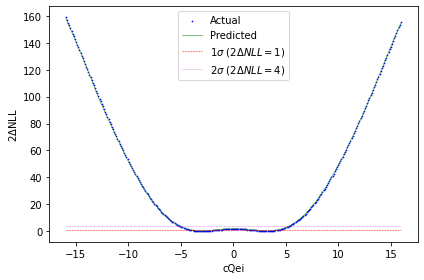

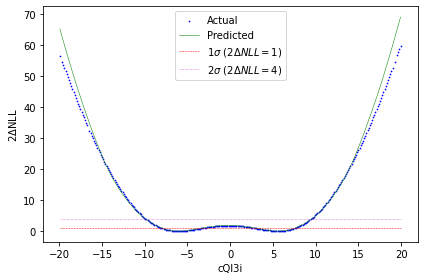

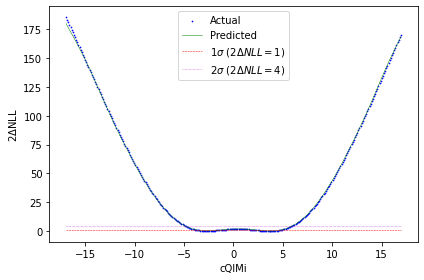

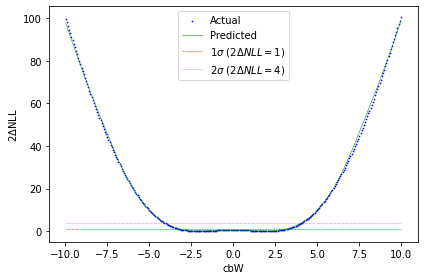

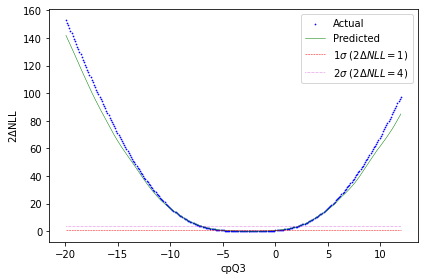

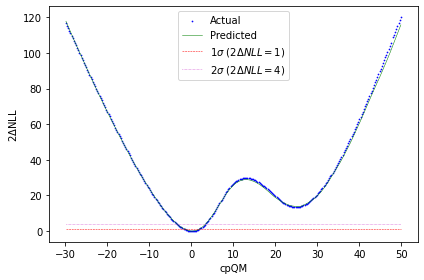

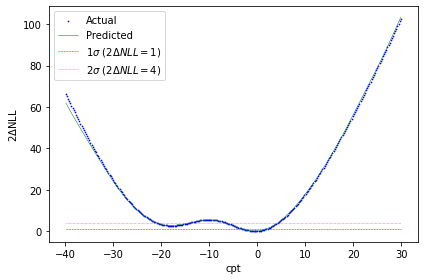

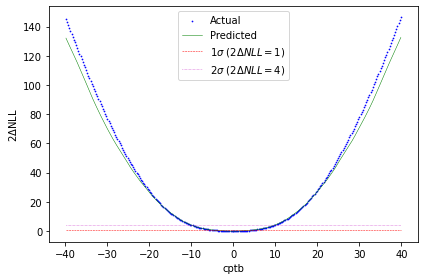

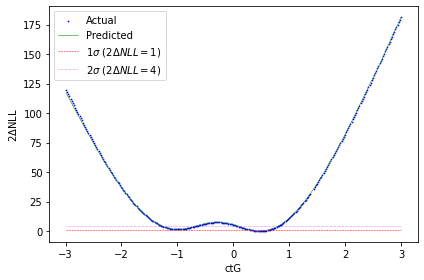

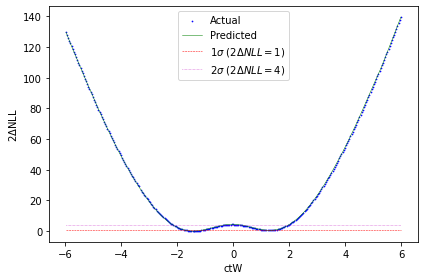

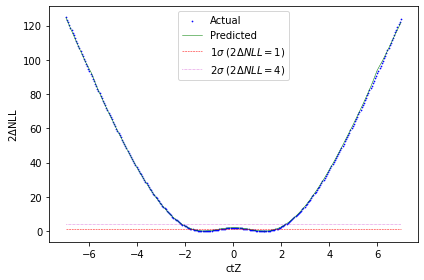

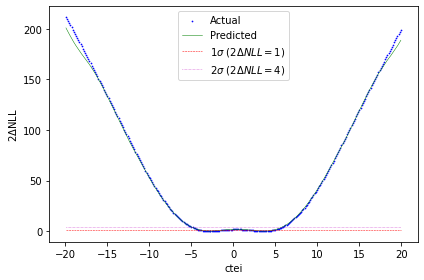

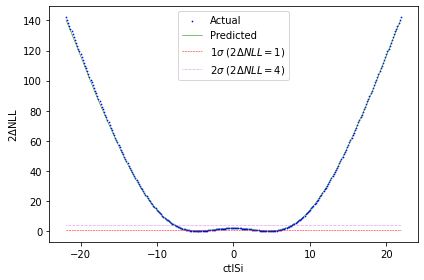

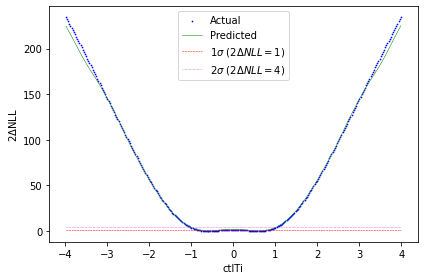

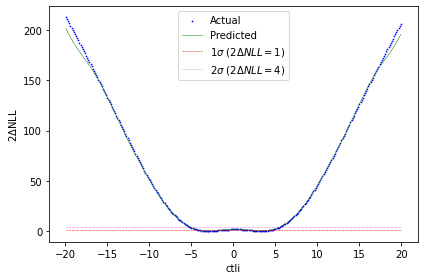

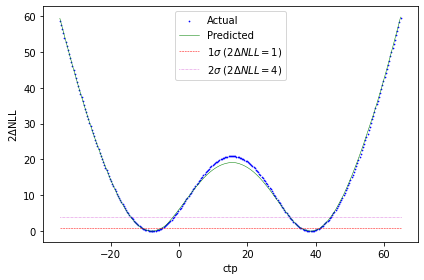

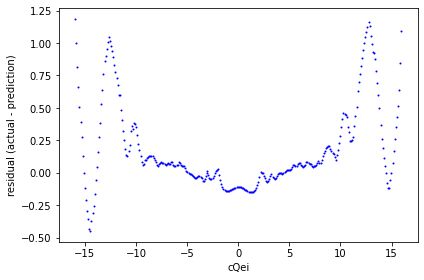

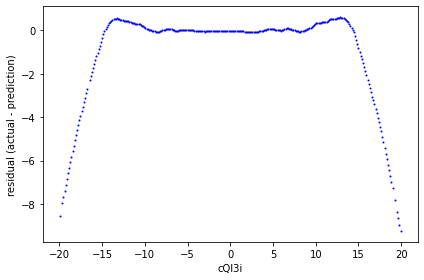

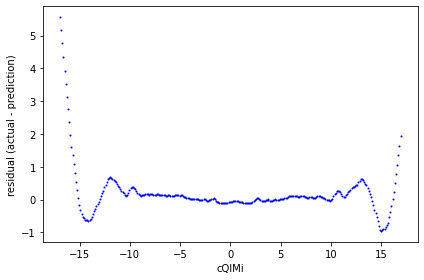

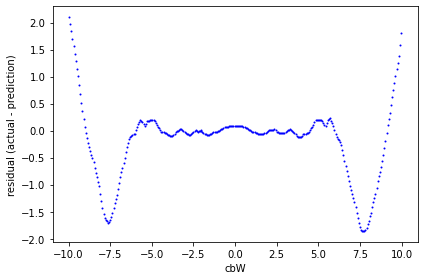

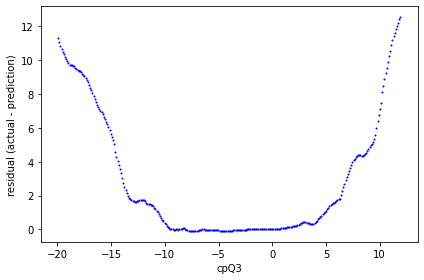

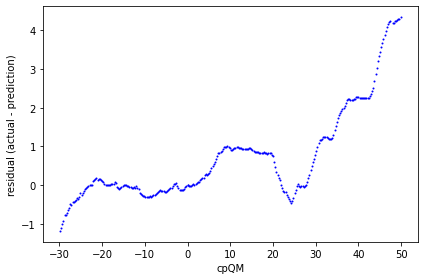

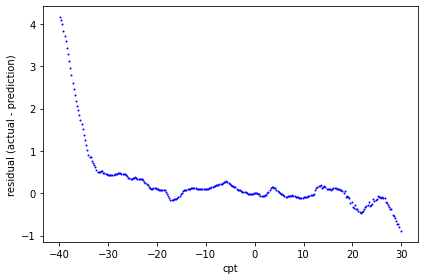

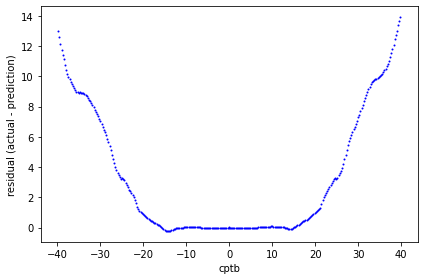

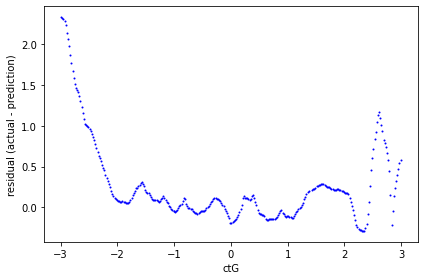

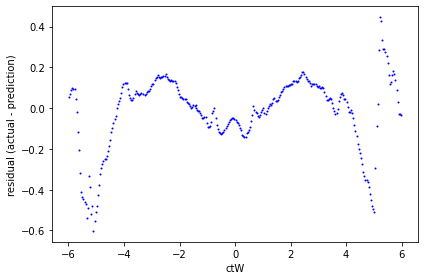

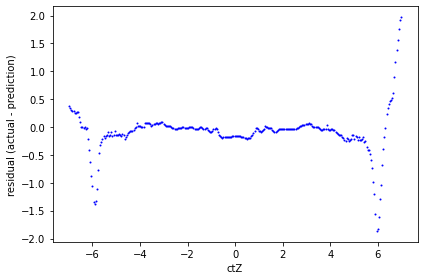

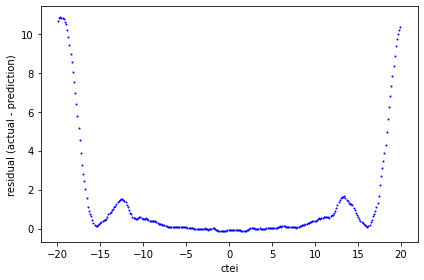

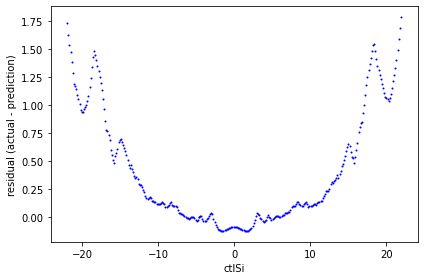

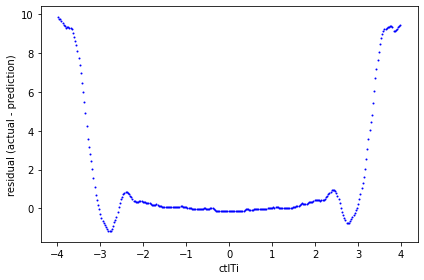

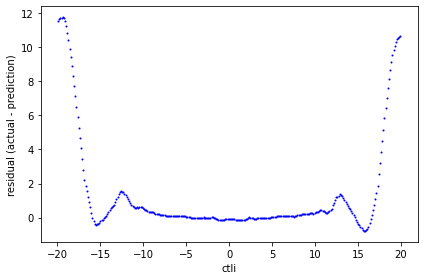

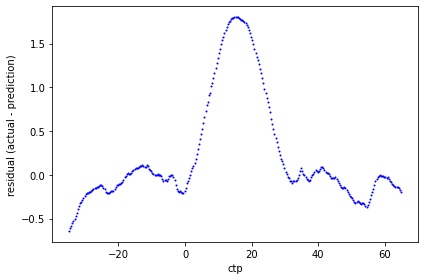

In [40]:
graphs = {}
diff_graphs = {}
for key in names.keys():
    graphs[key] = plt.subplots()
    actual_scatter = graphs[key][1].scatter(actual_graph_data[key][key], actual_graph_data[key]['deltaNLL'], c='b', s=0.5)
    model_line, = graphs[key][1].plot(model_graph_data[key][key], model_graph_data[key]['deltaNLL'], 'g-', linewidth=0.5)
    one_line, = graphs[key][1].plot(model_graph_data[key][key], np.full_like(model_graph_data[key][key], 1), 'r--', linewidth=0.5)
    four_line, = graphs[key][1].plot(model_graph_data[key][key], np.full_like(model_graph_data[key][key], 4), 'm:', linewidth=0.5)
    graphs[key][1].legend([actual_scatter, model_line, one_line, four_line], ['Actual', 'Predicted', '$1\sigma\ (2\Delta NLL=1)$', '$2\sigma\ (2\Delta NLL=4)$'])
    graphs[key][1].set_xlabel(key)
    graphs[key][1].set_ylabel('2$\Delta$NLL')
    graphs[key][0].tight_layout()

for key in names.keys():
    diff_graphs[key] = plt.subplots()
    diff_graphs[key][1].scatter(diff_graph_data[key][key], diff_graph_data[key]['deltaNLL'], c='b', s=1)
    diff_graphs[key][1].set_xlabel(key)
    diff_graphs[key][1].set_ylabel('residual (actual - prediction)')
    diff_graphs[key][0].tight_layout()

In [38]:
pp = PdfPages(f'{out_file}_validation.pdf')
for key in graphs.keys():
    pp.savefig(graphs[key][0])
for key in diff_graphs.keys():
    pp.savefig(diff_graphs[key][0])
pp.close()

In [34]:
# Test single points
loaded_data = np.load('../likelihood_data.npz')
use_it = (loaded_data['deltaNLL'] != 0)
use_it[0] = True # Keep the first of the repeated entries
outputs_all_full = loaded_data['deltaNLL'][use_it]
inputs_all_full = []
for key in names.keys():
    inputs_all_full.append(loaded_data[key][use_it])
inputs_all_full = np.stack(inputs_all_full, axis=1)

In [35]:
# Add the squares of the variables and cross terms
inputs_list = []
inputs_list.append(inputs_all_full)
inputs_all_full_squared = inputs_all_full ** 2
inputs_list.append(inputs_all_full_squared)
# Add the cross terms
for i in range(16):
    for j in range(i):
        inputs_list.append(np.expand_dims(inputs_all_full[:,i] *  inputs_all_full[:,j], axis=1))
inputs_all_full = np.concatenate(inputs_list, axis=1)

In [36]:
inputs_full = torch.from_numpy(inputs_all_full)
outputs_full = torch.unsqueeze(torch.from_numpy(outputs_all_full), 1)

In [51]:
outputs_full[outputs_full>100]

tensor([135.6018, 167.8350, 222.8773,  ..., 204.7773, 133.1834, 180.2299])

In [52]:
inputs_full[(outputs_full>100).squeeze()][0]

tensor([  -5.8947,   -7.4806,   -6.4999,   -5.2683,   -4.1522,  -12.9305,
          19.4844,   14.2265,   -2.8808,   -0.9376,    1.9327,   13.9969,
          19.7797,    1.7820,    0.8682,  -27.0396,   34.7470,   55.9589,
          42.2490,   27.7551,   17.2407,  167.1988,  379.6400,  202.3931,
           8.2992,    0.8790,    3.7352,  195.9128,  391.2361,    3.1755,
           0.7537,  731.1408,   44.0954,   38.3148,   48.6231,   31.0549,
          39.4100,   34.2436,   24.4757,   31.0607,   26.9889,   21.8750,
          76.2211,   96.7278,   84.0475,   68.1221,   53.6901, -114.8536,
        -145.7540, -126.6468, -102.6496,  -80.9028, -251.9432,  -83.8603,
        -106.4222,  -92.4711,  -74.9496,  -59.0711, -183.9562,  277.1940,
          16.9815,   21.5502,   18.7251,   15.1771,   11.9617,   37.2506,
         -56.1310,  -40.9840,    5.5266,    7.0135,    6.0941,    4.9394,
           3.8929,   12.1232,  -18.2678,  -13.3382,    2.7010,  -11.3924,
         -14.4575,  -12.5622,  -10.181

In [55]:
model(inputs_full[(outputs_full>100).squeeze()][2])

tensor([89.9861], grad_fn=<AddBackward0>)

In [56]:
inputs_full[10000]

tensor([ 6.3238e-01, -7.0462e+00, -6.2290e+00,  3.1898e+00, -1.4668e+01,
        -2.6391e+01, -1.2780e+01, -9.6845e+00,  7.2537e-01,  3.5702e+00,
        -3.5659e+00, -7.4998e+00, -1.4679e+01, -1.6153e+00, -1.3331e+01,
         5.4334e+01,  3.9990e-01,  4.9649e+01,  3.8801e+01,  1.0175e+01,
         2.1516e+02,  6.9647e+02,  1.6334e+02,  9.3790e+01,  5.2616e-01,
         1.2746e+01,  1.2715e+01,  5.6248e+01,  2.1547e+02,  2.6093e+00,
         1.7771e+02,  2.9522e+03, -4.4559e+00, -3.9391e+00,  4.3891e+01,
         2.0172e+00, -2.2476e+01, -1.9869e+01, -9.2760e+00,  1.0336e+02,
         9.1370e+01, -4.6789e+01, -1.6689e+01,  1.8595e+02,  1.6439e+02,
        -8.4181e+01,  3.8711e+02, -8.0820e+00,  9.0053e+01,  7.9609e+01,
        -4.0767e+01,  1.8747e+02,  3.3728e+02, -6.1243e+00,  6.8239e+01,
         6.0325e+01, -3.0891e+01,  1.4206e+02,  2.5558e+02,  1.2377e+02,
         4.5871e-01, -5.1111e+00, -4.5183e+00,  2.3138e+00, -1.0640e+01,
        -1.9143e+01, -9.2705e+00, -7.0248e+00,  2.2

In [57]:
outputs_full[10000]

tensor([165.9285])

In [58]:
model(inputs_full[10000])

tensor([293.9904], grad_fn=<AddBackward0>)